# Fine-Tuning Shallow Neural Networks With Keras

For a more detailed breakdown of the code, check out the full tutorial [on the Paperspace blog](https://blog.paperspace.com/fine-tuning-shallow-networks-keras/).

In [ ]:
# !pip install keras
# !pip install --upgrade tensorflow

In [3]:
import keras

(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

print('x_train.shape =',x_train.shape)
print('y_train.shape =',y_train.shape)
print('x_test.shape =',x_test.shape)
print('y_test.shape =',y_test.shape)

4423680/4422102 [==============================] - 0s 0us/step
x_train.shape = (60000, 28, 28)
y_train.shape = (60000,)
x_test.shape = (10000, 28, 28)
y_test.shape = (10000,)


In [4]:
import numpy as np

list_categories = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
num_classes = np.unique(y_test).shape[0] #len(list_categories)
print('num_classes =', num_classes)

num_classes = 10


In [5]:
x_train_norm = x_train/255
x_test_norm = x_test/255

In [6]:
final_train_imageset = np.expand_dims(x_train_norm, axis = 3)
final_test_imageset = np.expand_dims(x_test_norm, axis = 3)

y_train2 = np.expand_dims(y_train, axis = 1)
y_test2 = np.expand_dims(y_test, axis = 1)

print('final_train_imageset.shape =', final_train_imageset.shape)
print('final_test_imageset.shape =', final_test_imageset.shape)
print('y_train2.shape =', y_train2.shape)
print('y_test2.shape =', y_test2.shape)

final_train_imageset.shape = (60000, 28, 28, 1)
final_test_imageset.shape = (10000, 28, 28, 1)
y_train2.shape = (60000, 1)
y_test2.shape = (10000, 1)


In [7]:
final_train_label = keras.utils.to_categorical(y_train2, num_classes)
final_test_label = keras.utils.to_categorical(y_test2, num_classes)

print('final_train_label.shape =',final_train_label.shape)
print('final_test_label.shape =',final_test_label.shape)

final_train_label.shape = (60000, 10)
final_test_label.shape = (10000, 10)


In [8]:
print(x_train.shape[1], x_train.shape[2])
print(x_train.shape[1]*x_train.shape[2])
print((x_train.shape[1]*x_train.shape[2])//100)

28 28
784
7


In [16]:
percentile = 0.5 # 1.0, 0.5, 0.1, 0.01

NUM_NEURONS = int((x_train.shape[1]*x_train.shape[2])*percentile)
NUM_LAYERS = 1
BATCH_SIZE = 128
NUM_EPOCHS = 3000
LEARNING_RATE = 0.0001
EPSILON = 1e-4
DROPOUT = 0.5 # 0.5, 0.8

LOSS = 'categorical_crossentropy'
DENSE_ACTIVATION_FUNCTION = 'default' # default, relu, LeakyReLU, PReLU, ELU
FINAL_ACTIVATION_FUNCTION = 'softmax'
early_stop_after_epochs = 50 # stop after 50 consecutive epochs with no improvement
validation_split = 0.1

checkpointer_name = "weights.Dense.Fashion.nLayers"+str(NUM_LAYERS)+".nNeurons"+str(NUM_NEURONS)+".act."+DENSE_ACTIVATION_FUNCTION+".p"+str(percentile)+".dropout"+str(DROPOUT)+".batch"+str(BATCH_SIZE)+".hdf5"
print(checkpointer_name)

weights.Dense.Fashion.nLayers1.nNeurons392.act.default.p0.5.dropout0.5.batch128.hdf5


In [17]:
def dense_activation():
    if DENSE_ACTIVATION_FUNCTION == 'relu':
        keras.layers.ReLU(max_value=None, negative_slope=0, threshold=0)
    elif DENSE_ACTIVATION_FUNCTION == 'LeakyReLU':
        keras.layers.LeakyReLU(alpha=0.3)
    elif DENSE_ACTIVATION_FUNCTION == 'PReLU':
        keras.layers.PReLU(tf.initializers.constant(0.3)) # "zeros"
    elif DENSE_ACTIVATION_FUNCTION == 'ELU':
        keras.layers.ELU(alpha=1.0)
    elif DENSE_ACTIVATION_FUNCTION == 'default':
        return None

In [18]:
'''
def Dense(
    units, activation=None, use_bias=True, kernel_initializer='glorot_uniform', 
    bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, 
    activity_regularizer=None, kernel_constraint=None, bias_constraint=None, **kwargs
    )
'''

"\ndef Dense(\n    units, activation=None, use_bias=True, kernel_initializer='glorot_uniform', \n    bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, \n    activity_regularizer=None, kernel_constraint=None, bias_constraint=None, **kwargs\n    )\n"

In [19]:
from keras.layers import *
from keras.models import * #Model, load_model

input_shape = final_train_imageset.shape[1:]
inputs = Input(input_shape)

x = inputs
for _ in range(NUM_LAYERS):
    x = Dense(NUM_NEURONS, activation=dense_activation())(x)
    x = Dropout(DROPOUT)(x)

x = Flatten()(x)
outputs = Dense(num_classes, activation=FINAL_ACTIVATION_FUNCTION)(x)

model = Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
dense_2 (Dense)              (None, 28, 28, 392)       784       
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 28, 392)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 307328)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                3073290   
Total params: 3,074,074
Trainable params: 3,074,074
Non-trainable params: 0
_________________________________________________________________


In [20]:
optimizer_1 = keras.optimizers.RMSprop(lr = LEARNING_RATE, epsilon=EPSILON)
optimizer_2 = keras.optimizers.Adam(lr = LEARNING_RATE, epsilon=EPSILON, beta_1=0.9, beta_2=0.999, amsgrad=False)
optimizer_3 = keras.optimizers.SGD(lr = LEARNING_RATE, momentum=0.85)

model.compile(
    optimizer=optimizer_2, # 'Adam', optimizer_1, optimizer_3
    loss=['categorical_crossentropy', 'mean_squared_error', 'mean_absolute_error', 
          'mean_absolute_percentage_error', 'mean_squared_logarithmic_error'],
    metrics=['accuracy', 'Precision', 'Recall']
)

In [21]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LambdaCallback

checkpointer_best = ModelCheckpoint(filepath = checkpointer_name, 
                                    monitor='val_loss', 
                                    save_weights_only=False,
                                    mode='auto',  
                                    verbose = 2, 
                                    save_best_only = True
                                    )
early_stopping = EarlyStopping(monitor='val_loss', patience=early_stop_after_epochs)

In [22]:
list_callbacks = [checkpointer_best, early_stopping]

history = model.fit(final_train_imageset, final_train_label, 
                    shuffle=True, 
                    batch_size = BATCH_SIZE, 
                    epochs = NUM_EPOCHS, 
                    #steps_per_epoch = 2,
                    validation_split = validation_split, 
                    #validation_data = (final_test_imageset, final_test_label),
                    callbacks=list_callbacks
                    )

Epoch 1/5
422/422 [==============================] - 159s 376ms/step - loss: 0.9068 - accuracy: 0.7036 - precision: 0.8589 - recall: 0.5058 - val_loss: 0.4946 - val_accuracy: 0.8212 - val_precision: 0.8609 - val_recall: 0.7767

Epoch 00001: val_loss improved from inf to 0.49460, saving model to weights.Dense.Fashion.nLayers1.nNeurons392.act.default.p0.5.dropout0.5.batch128.hdf5
Epoch 2/5
422/422 [==============================] - 159s 376ms/step - loss: 0.4688 - accuracy: 0.8383 - precision: 0.8799 - recall: 0.7923 - val_loss: 0.4473 - val_accuracy: 0.8403 - val_precision: 0.8789 - val_recall: 0.8035

Epoch 00002: val_loss improved from 0.49460 to 0.44727, saving model to weights.Dense.Fashion.nLayers1.nNeurons392.act.default.p0.5.dropout0.5.batch128.hdf5
Epoch 3/5
422/422 [==============================] - 158s 373ms/step - loss: 0.4434 - accuracy: 0.8453 - precision: 0.8814 - recall: 0.8095 - val_loss: 0.4180 - val_accuracy: 0.8505 - val_precision: 0.8874 - val_recall: 0.8200

Epoch 

In [23]:
model_loaded = load_model(checkpointer_name)
result = model_loaded.evaluate(final_test_imageset, final_test_label)

313/313 [==============================] - 7s 20ms/step - loss: 0.4455 - accuracy: 0.8436 - precision: 0.8784 - recall: 0.8118


### Plotting

In [24]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'], loc = 'best')

img_path = 'vLoss_'+checkpointer_name[8:-5]+'.png'
plt.savefig(img_path, dpi=600)
plt.show()
print('img_path =', img_path)

<Figure size 640x480 with 1 Axes>

img_path = vLoss_Dense.Fashion.nLayers1.nNeurons392.act.default.p0.5.dropout0.5.batch128.png


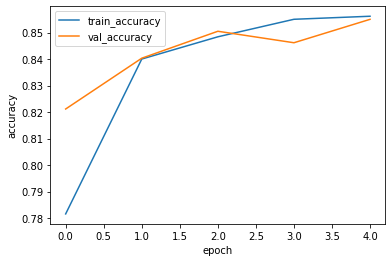

img_path = vAcc_Dense.Fashion.nLayers1.nNeurons392.act.default.p0.5.dropout0.5.batch128.png


In [25]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy','val_accuracy'], loc = 'best')

img_path = 'vAcc_'+checkpointer_name[8:-5]+'.png'
plt.savefig(img_path, dpi=600)
plt.show()
print('img_path =', img_path)